In [8]:
!wget https://raw.githubusercontent.com/thorer/MLOPS/main/kaggle.json

--2022-06-18 15:30:44--  https://raw.githubusercontent.com/thorer/MLOPS/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      71  --.-KB/s    in 0s      

2022-06-18 15:30:44 (1.58 MB/s) - ‘kaggle.json’ saved [71/71]



In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:13<00:00, 190MB/s]
100% 2.29G/2.29G [00:13<00:00, 182MB/s]


In [ ]:
!mkdir train



In [ ]:
!unzip chest-xray-pneumonia.zip -d train



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: tr

In [ ]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

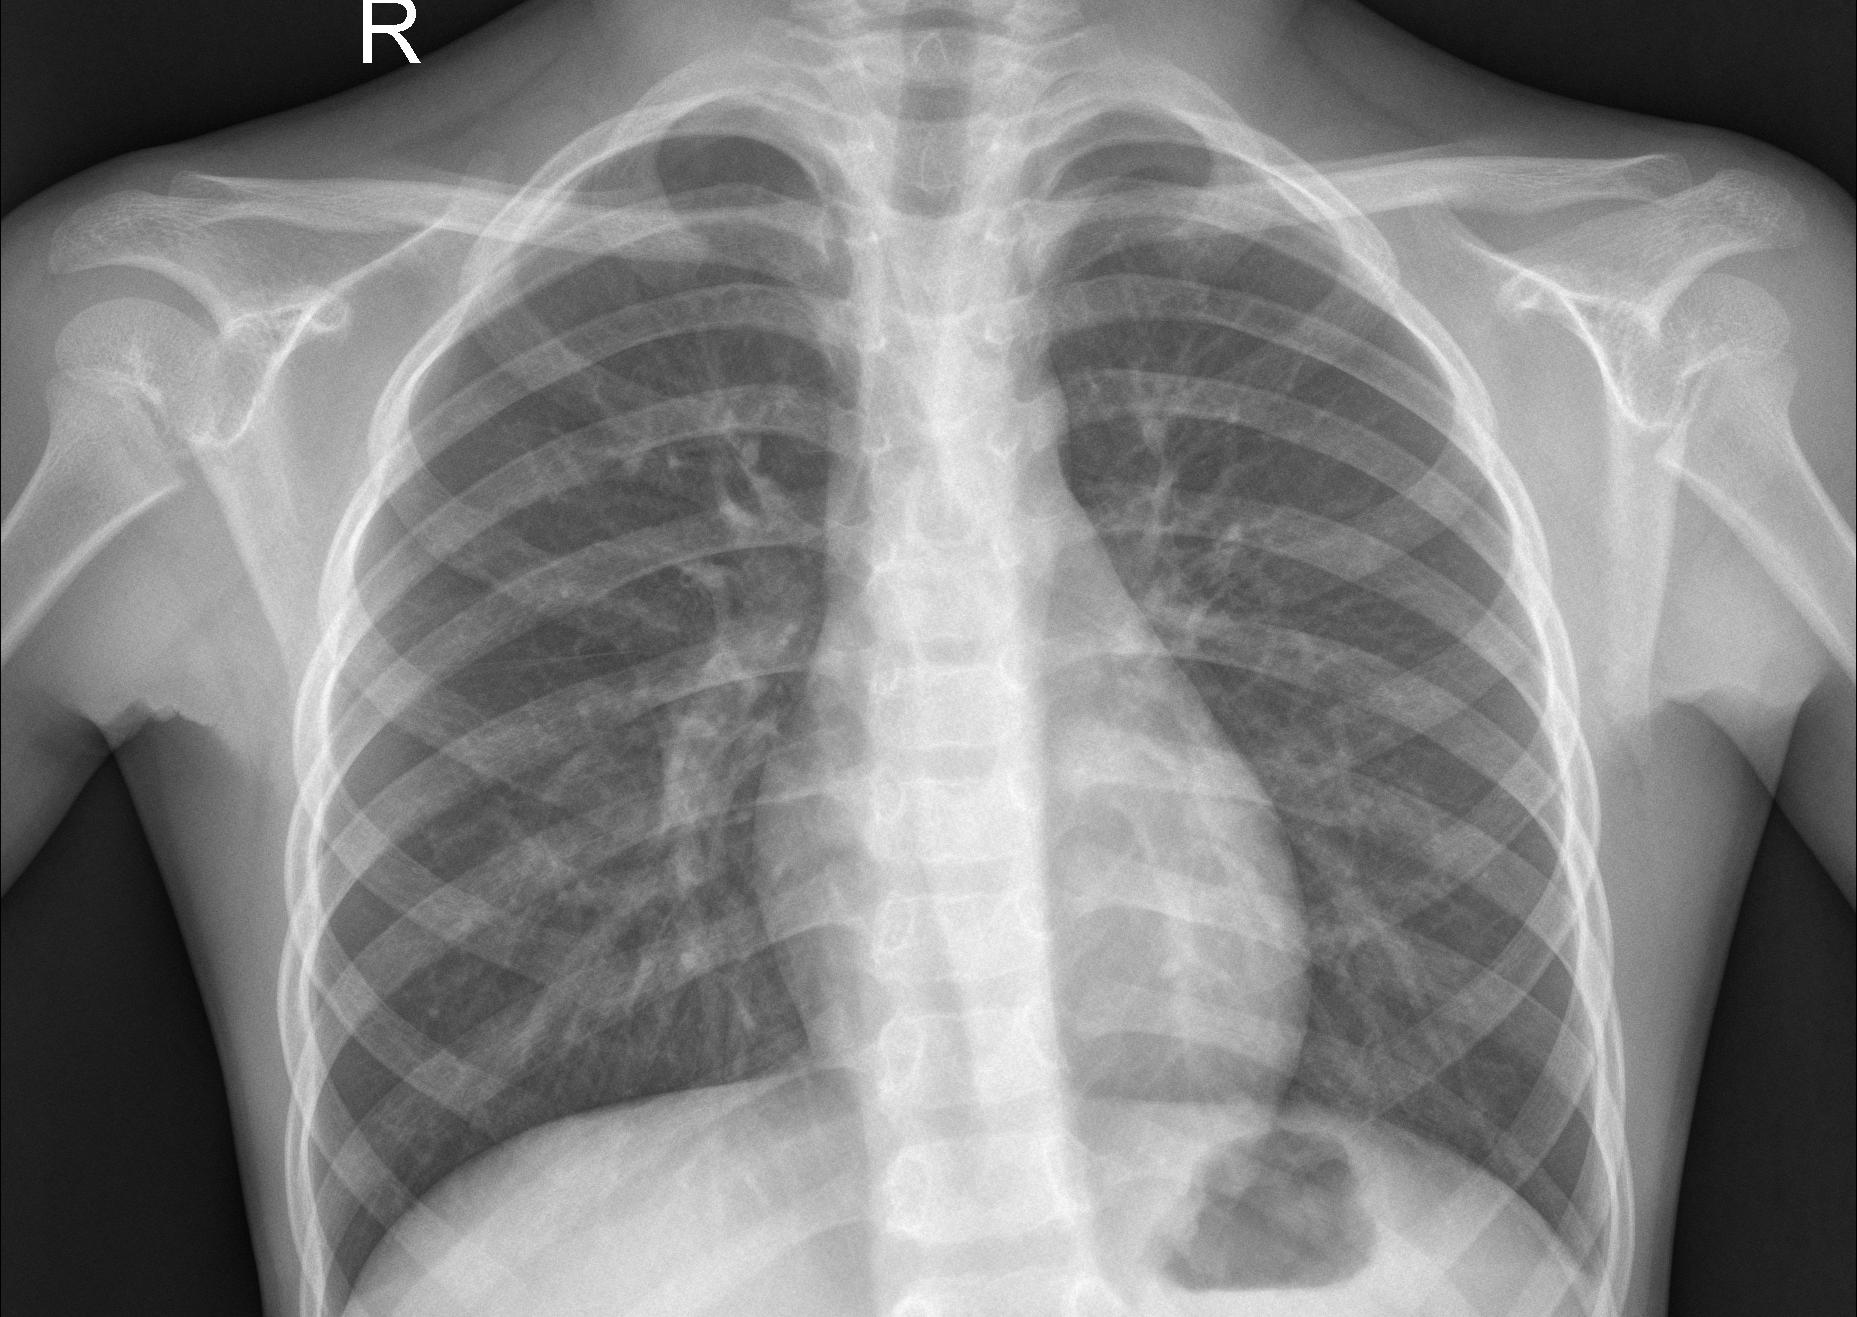

In [ ]:
display(Image('/content/train/chest_xray/test/NORMAL/IM-0001-0001.jpeg'))

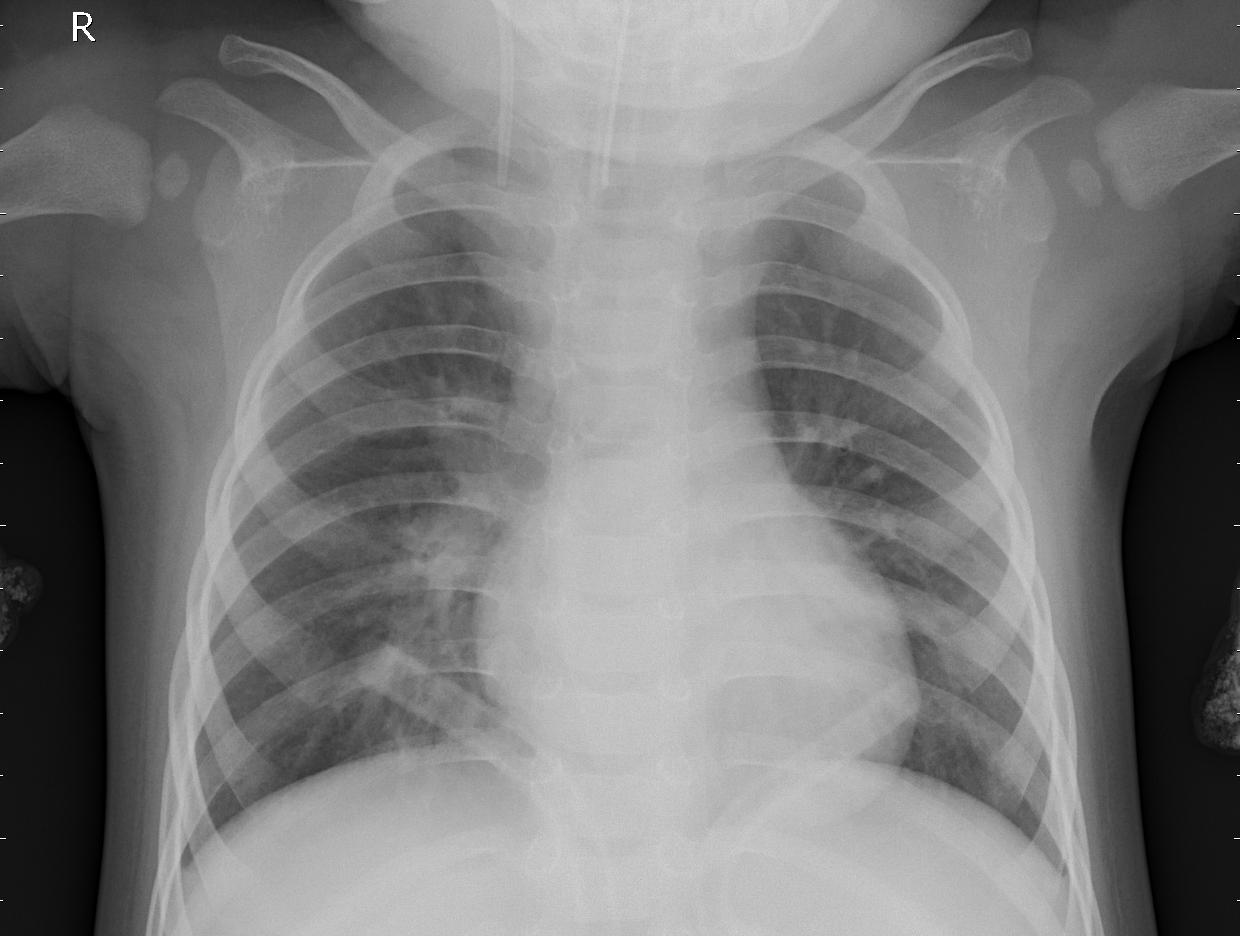

In [ ]:
display(Image('/content/train/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg'))

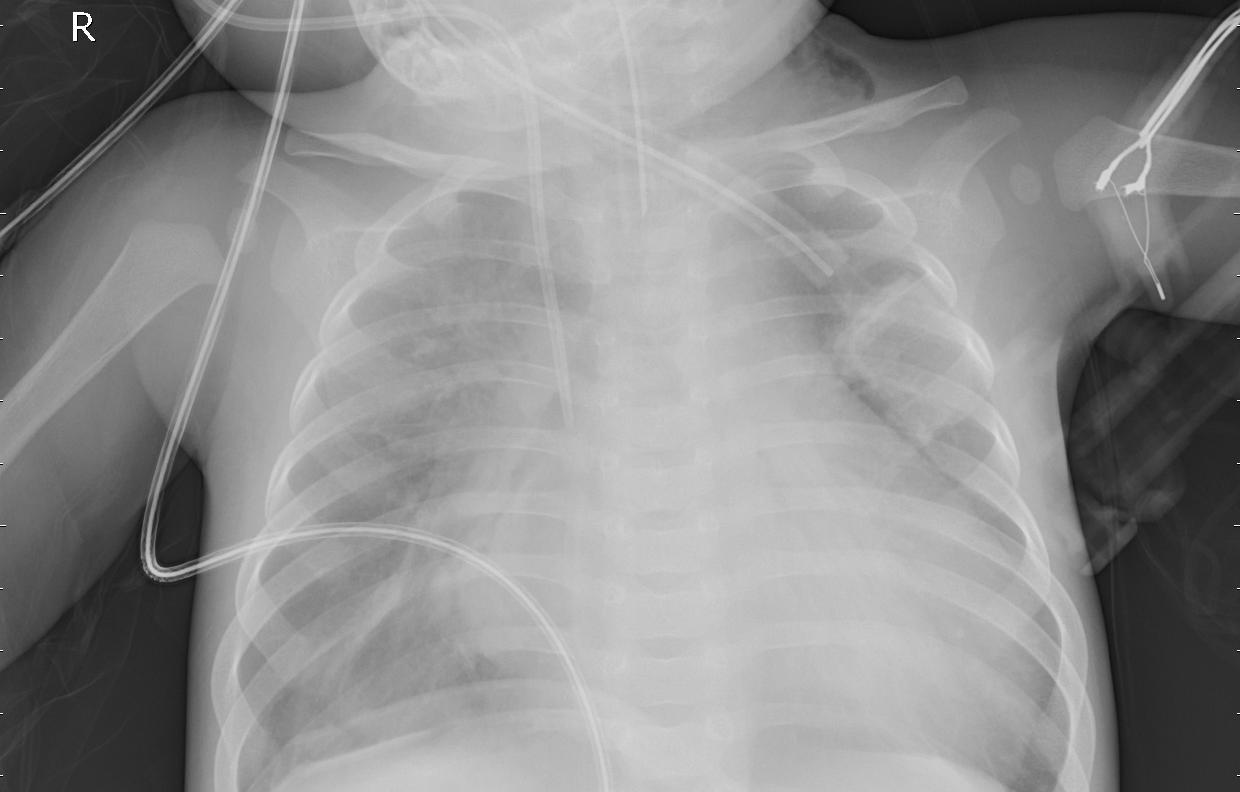

In [ ]:
display(Image('/content/train/chest_xray/train/PNEUMONIA/person1008_bacteria_2939.jpeg'))

In [ ]:
!find /content/train/chest_xray/test -type f | wc -l

624


In [ ]:
!find /content/train/chest_xray/train -type f | wc -l

5216


In [ ]:
!find /content/train/chest_xray/val -type f | wc -l

16


In [ ]:
batch_size = 128
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/train/chest_xray/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/train/chest_xray/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/train/chest_xray/val',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16 files belonging to 2 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [ ]:
classes=train_ds.class_names
print(classes)

['NORMAL', 'PNEUMONIA']


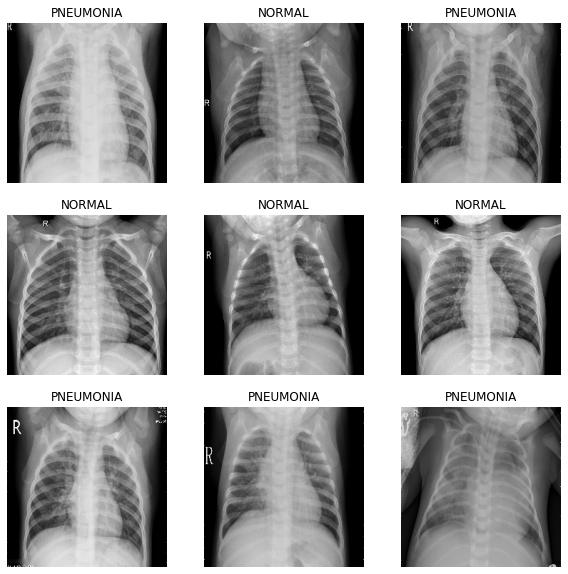

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
tf.random.set_seed(111)

In [ ]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
41/41 [==============================] - 125s 3s/step - loss: 0.1624 - accuracy: 0.9385 - val_loss: 0.2596 - val_accuracy: 0.8750
Epoch 2/5
41/41 [==============================] - 127s 3s/step - loss: 0.1417 - accuracy: 0.9482 - val_loss: 0.2388 - val_accuracy: 0.9375
Epoch 3/5
41/41 [==============================] - 126s 3s/step - loss: 0.1197 - accuracy: 0.9580 - val_loss: 0.2155 - val_accuracy: 0.9375
Epoch 4/5
41/41 [==============================] - 127s 3s/step - loss: 0.1135 - accuracy: 0.9605 - val_loss: 0.2133 - val_accuracy: 0.9375
Epoch 5/5
41/41 [==============================] - 126s 3s/step - loss: 0.1065 - accuracy: 0.9624 - val_loss: 0.1936 - val_accuracy: 0.9375


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


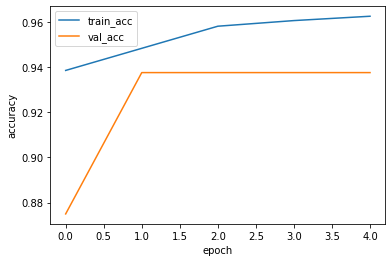

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [ ]:
result=model.evaluate(test_ds)

5/5 [==============================] - 18s 3s/step - loss: 0.4226 - accuracy: 0.8253


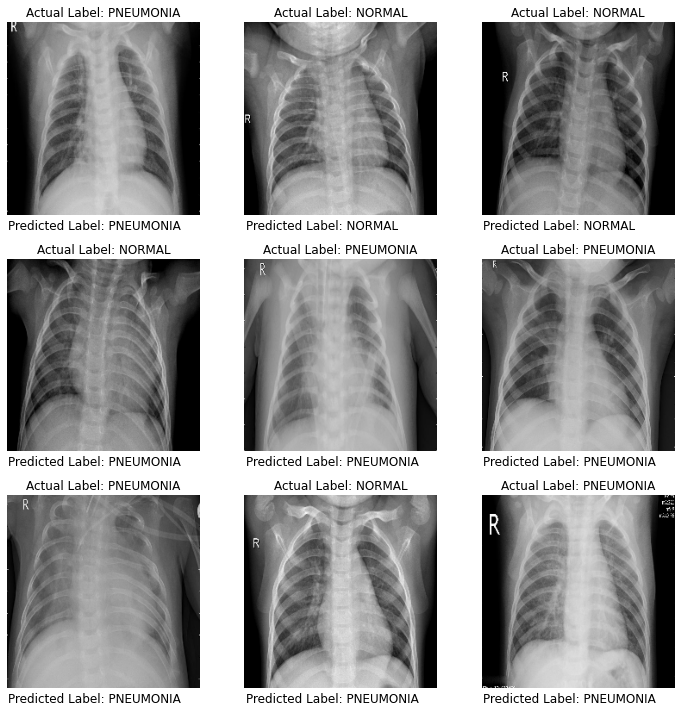

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [ ]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets
